# 5. Chemical space network for floral scents

## Purpose, contents, & conclusions

**Purpose:** In this notebook, the aroma & flavor data gathered in the previous notebooks is used to create a visualization (a *chemical space network*) of the types of molecules that give rise to floral smells.

**Contents:** The notebook shows:
* The calculation of similarities between all molecules in the data set (appx 1800 x 1800 = 3.2 million similarities) on the basis of several different molecular fingerprinting strategies.
* Comparisons of how well the different fingerprinting strategies work in differentiating the classes of molecules of interest (i.e.: those that smell floral vs. those that do not). Comparisons are conducted both quantitatively and visually.

**Conclusions:** Key conclusions and outputs are:
* For this data set, comparing molecules' structural similarity by 4-bond extended-connectivity fingerprints (ECFP4) gave the most readily interpretable visual representation of similarity groups.
* Visiualizing only the highest 3.5% of molecular similarities also aided in providing a clean, digestable visualization. A lower threshold resulted in too little clustering between similar molecules, and a higher threshold resulted in dense, overlapping clusters that did not make visual sense.
* All findings were used to create an infographic, `floral-chemical-network.png`, which is embedded at the very bottom of the notebook.

## Prepare the data

### Import the CSV data

In [1]:
import csv

In [2]:
aromas_flavors = []
with open("processed-data/aromas-flavors-validated.csv", "r") as file:
    reader = csv.DictReader(file, delimiter = "\t")
    for entry in reader:
        aromas_flavors.append(entry)

In [3]:
aromas_flavors[0]

{'common_name': '(+)-menthofuran',
 'SMILES_code': 'CC1CCC2=C(C1)OC=C2C',
 'InChI_code': 'InChI=1S/C10H14O/c1-7-3-4-9-8(2)6-11-10(9)5-7/h6-7H,3-5H2,1-2H3/t7-/m1/s1',
 'aroma': 'floral fatty fruity|citrusy fruity',
 'flavor': ''}

### Interpret the chemical structures

The `aromas_flavors` list of dicts contains information about each molecule's structure encoded as both SMILES codes and InChI codes. These are machine-readable into molecular representations via RDKit. Create an RDKit molecule for each entry in the data set:

In [4]:
from rdkit import Chem

In [5]:
for molecule in aromas_flavors:
    molecule["rdkit_mol"] = Chem.inchi.MolFromInchi(molecule["InChI_code"])

### Clean up the chemical data

Most of the RDKit "molecules" are one covalently bound fragment as expected, but some of them might not be (such as salts, mixtures, etc.). For the purpose of this visualization, we only want the chemicals with a single fragment.

In [6]:
fragment_counts = []
for molecule in aromas_flavors:
    fragment_counts.append(len(Chem.GetMolFrags(molecule["rdkit_mol"])))
print("All molecules are a single fragment? ", str(all(fragments == 1 for fragments in fragment_counts)))

All molecules are a single fragment?  False


Drop the entries that contain > 1 fragment:

In [7]:
starting_num_mols = len(aromas_flavors)
for i, molecule in enumerate(aromas_flavors):
    if len(Chem.GetMolFrags(molecule["rdkit_mol"])) != 1:
        aromas_flavors.pop(i)
ending_num_mols = len(aromas_flavors)
print("Started with: ", starting_num_mols, " ==> Dropped to: ", ending_num_mols)

Started with:  1774  ==> Dropped to:  1728


In [8]:
aromas_flavors[0]

{'common_name': '(+)-menthofuran',
 'SMILES_code': 'CC1CCC2=C(C1)OC=C2C',
 'InChI_code': 'InChI=1S/C10H14O/c1-7-3-4-9-8(2)6-11-10(9)5-7/h6-7H,3-5H2,1-2H3/t7-/m1/s1',
 'aroma': 'floral fatty fruity|citrusy fruity',
 'flavor': '',
 'rdkit_mol': <rdkit.Chem.rdchem.Mol at 0x7ff637390900>}

### One-hot encode aroma data

Right now, the aromas & flavors data in `aromas_flavors` is not in a terribly useful format. For convenience of plotting, we'll eventually want a binary column that indicates whether or not a given molecule smells, for example, floral.

First, create a dataframe `aroma` with the molcules & a description of their smell.

In [9]:
aromas_dict = {}
for mol in aromas_flavors:
    aromas_dict[mol["common_name"]] = [mol["aroma"]]

In [10]:
import pandas as pd

In [11]:
aromas = pd.DataFrame.from_dict(aromas_dict, orient = "index")
aromas.columns = ["aroma"]
aromas.head()

,aroma
(+)-menthofuran,floral fatty fruity|citrusy fruity
1-hepten-3-ol,dairy fatty
"2,4,8-trimethyl-7-nonen-2-ol",fruity|citrusy fruity
"4,7,7-trimethyl-6-thiabicyclo[3.2.1]octane",earthy fruity|citrusy savory
diosphenol,vegetal|herbal fruity|berry vegetal


Then, one-hot encode the aroma data, with one new column for each category of smell.

In [12]:
import math

In [13]:
def aroma_category_encoder(row):
    descriptors_fine = row["aroma"].split(" ")
    descriptors_coarse = [cat.split("|")[0] for cat in descriptors_fine]
    if len(descriptors_coarse) > 0:
        for descriptor in descriptors_coarse:
            if isinstance(descriptor, str) and descriptor != "nan" and len(descriptor) > 0:
                row[descriptor] = 1
    return row

In [14]:
aromas = aromas.apply(aroma_category_encoder, axis = "columns")
aromas = aromas.fillna(value = 0)
aromas.drop(columns = ["aroma"], inplace = True)
aromas.head()

,brown,dairy,earthy,fatty,floral,fruity,liquorlike,minty,savory,sharp,starchy,sweet,vegetal
(+)-menthofuran,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-hepten-3-ol,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2,4,8-trimethyl-7-nonen-2-ol",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"4,7,7-trimethyl-6-thiabicyclo[3.2.1]octane",0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
diosphenol,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Let's see how many molecules are in each of the categories:

In [15]:
aromas.sum()

brown         233.0
dairy         144.0
earthy        232.0
fatty         132.0
floral        324.0
fruity        608.0
liquorlike     62.0
minty          31.0
savory        170.0
sharp         650.0
starchy        29.0
sweet         116.0
vegetal       358.0
dtype: float64

Great; the `floral` candidate of interest has enough representation to be meaningful, but enough out-of-class representation that real comparisons can be drawn. Other descriptors aren't great candidates for this approach; for example, `minty` is likely too specific, while `sharp` appears to be too general to the point of being over-represented.

## Determine chemical similarities

Next, we'll determine how similar each molecule in `aromas` is to all the other molecules. These similarities will ultimately be used to place the molecules on our chemical space network: molecules that are more similar to one another will be placed closer together.

Similarities will be calculated based on molecular fingerprints, but there are a variety of different methods for determining a molecule's fingerprint. It is not necessarily clear which one will be the best choice for this data set, so I will try several and compare the results:

### from MACCS fingerprints

First up, MACCS fingerprints. These use a set of 166 pre-defined structural features to create each fingerprint.

Calculate the MACCS fingerprints:

In [16]:
from rdkit.Chem import MACCSkeys

In [17]:
for molecule in aromas_flavors:
    molecule["MACCS_fingerprint"] = MACCSkeys.GenMACCSKeys(molecule["rdkit_mol"])

Then, use the fingerprints to calculate similarities for each of the molecules in the data set. There are a variety of ways to calculate similarity from fingerprints, but Tanimoto similarity seems to be the most common for this application.

In [18]:
mol_names = [mol["common_name"] for mol in aromas_flavors]
maccs_fingerprints = [mol["MACCS_fingerprint"] for mol in aromas_flavors]

In [19]:
from rdkit import DataStructs
from tqdm import tqdm

In [20]:
sims_maccs = [] # This will become a list of lists, with one component list for each molecule
for fingerprint1 in tqdm(maccs_fingerprints):
    newrow = []
    for fingerprint2, name2 in zip(maccs_fingerprints, mol_names):
        newrow.append(DataStructs.TanimotoSimilarity(fingerprint1, fingerprint2))
    sims_maccs.append(newrow)

100%|██████████| 1728/1728 [00:06<00:00, 255.07it/s]


Convert the similarities into a matrix:

In [21]:
matrix_maccs = pd.DataFrame(sims_maccs, columns = mol_names)
matrix_maccs.index = mol_names
matrix_maccs.head()

,(+)-menthofuran,1-hepten-3-ol,"2,4,8-trimethyl-7-nonen-2-ol","4,7,7-trimethyl-6-thiabicyclo[3.2.1]octane",diosphenol,2-butanol,3-sulfanylbutyl acetate,4-ethyloctanal,4-mercapto-4-methyl-2-pentanol,ethyl 2-hydroxy-2-methylbutanoate,...,gamma-undecalactone,gamma-valerolactone,delta-damascone,delta-dodecalactone,delta-hexalactone,delta-octalactone,6-hexyltetrahydro-2h-pyran-2-one,7-butyloxepan-2-one,7-hexyloxepan-2-one,ambrettolide
(+)-menthofuran,1.000000,0.258065,0.323529,0.500000,0.297297,0.222222,0.264706,0.440000,0.176471,0.205128,...,0.533333,0.500000,0.275862,0.483871,0.482759,0.451613,0.483871,0.419355,0.451613,0.290323
1-hepten-3-ol,0.258065,1.000000,0.538462,0.142857,0.387097,0.555556,0.407407,0.409091,0.346154,0.354839,...,0.366667,0.321429,0.185185,0.366667,0.310345,0.333333,0.366667,0.392857,0.379310,0.206897
"2,4,8-trimethyl-7-nonen-2-ol",0.323529,0.538462,1.000000,0.352941,0.531250,0.416667,0.375000,0.423077,0.518519,0.454545,...,0.342857,0.303030,0.407407,0.342857,0.294118,0.314286,0.342857,0.323529,0.352941,0.205882
"4,7,7-trimethyl-6-thiabicyclo[3.2.1]octane",0.500000,0.142857,0.352941,1.000000,0.289474,0.096774,0.257143,0.321429,0.281250,0.200000,...,0.342857,0.303030,0.357143,0.305556,0.294118,0.277778,0.305556,0.285714,0.314286,0.171429
diosphenol,0.297297,0.387097,0.531250,0.289474,1.000000,0.233333,0.342857,0.290323,0.257143,0.342105,...,0.388889,0.437500,0.464286,0.428571,0.468750,0.400000,0.428571,0.371429,0.400000,0.294118


All done. I'll come back to this matrix after calculating similarity scores using the other fingerprint techniques.

### from extended-connectivity fingerprints, radius = 2 bonds

Next up, extended-connectivity fingerprints (ECFP, which RDKit calls "Morgan fingerprints"). Unlike MACCS fingerprints, these do *not* rely on predefined structural features. Instead, this method creates fragments centered on each atom and encompassing all the other atoms up to a certain number of bonds away. Here, I'll use a 2-bond radius to create ECFP data.

Calculate the fingerprints for each molecule first:

In [22]:
from rdkit.Chem import AllChem

In [23]:
for molecule in aromas_flavors:
    molecule["ecfp2_fingerprint"] = AllChem.GetMorganFingerprint(molecule["rdkit_mol"], 2)

In [24]:
ecfp2_fingerprints = [mol["ecfp2_fingerprint"] for mol in aromas_flavors]

Then calculate similarities & create a matrix:

In [25]:
sims_ecfp2 = []
for fingerprint1 in tqdm(ecfp2_fingerprints):
    newrow = []
    for fingerprint2, name2 in zip(ecfp2_fingerprints, mol_names):
        newrow.append(DataStructs.TanimotoSimilarity(fingerprint1, fingerprint2))
    sims_ecfp2.append(newrow)

100%|██████████| 1728/1728 [00:04<00:00, 351.79it/s]


In [26]:
matrix_ecfp2 = pd.DataFrame(sims_ecfp2, columns = mol_names)
matrix_ecfp2.index = mol_names
matrix_ecfp2.head()

,(+)-menthofuran,1-hepten-3-ol,"2,4,8-trimethyl-7-nonen-2-ol","4,7,7-trimethyl-6-thiabicyclo[3.2.1]octane",diosphenol,2-butanol,3-sulfanylbutyl acetate,4-ethyloctanal,4-mercapto-4-methyl-2-pentanol,ethyl 2-hydroxy-2-methylbutanoate,...,gamma-undecalactone,gamma-valerolactone,delta-damascone,delta-dodecalactone,delta-hexalactone,delta-octalactone,6-hexyltetrahydro-2h-pyran-2-one,7-butyloxepan-2-one,7-hexyloxepan-2-one,ambrettolide
(+)-menthofuran,1.000000,0.019608,0.032258,0.150943,0.215686,0.050000,0.038462,0.033898,0.041667,0.037037,...,0.133333,0.219512,0.096774,0.145161,0.232558,0.180000,0.152542,0.160714,0.145161,0.090909
1-hepten-3-ol,0.019608,1.000000,0.173913,0.020000,0.061224,0.230769,0.128205,0.307692,0.142857,0.121951,...,0.160000,0.025641,0.035714,0.150943,0.023810,0.113636,0.160000,0.170213,0.150943,0.000000
"2,4,8-trimethyl-7-nonen-2-ol",0.032258,0.173913,1.000000,0.050000,0.103448,0.157895,0.191489,0.166667,0.268293,0.208333,...,0.060606,0.019608,0.093750,0.057971,0.018519,0.051724,0.060606,0.063492,0.057971,0.000000
"4,7,7-trimethyl-6-thiabicyclo[3.2.1]octane",0.150943,0.020000,0.050000,1.000000,0.129630,0.051282,0.039216,0.034483,0.065217,0.057692,...,0.080645,0.139535,0.175439,0.093750,0.155556,0.115385,0.098361,0.103448,0.093750,0.037500
diosphenol,0.215686,0.061224,0.103448,0.129630,1.000000,0.135135,0.102041,0.070175,0.136364,0.098039,...,0.152542,0.219512,0.096774,0.145161,0.204545,0.180000,0.152542,0.160714,0.145161,0.076923


### from extended-connectivity fingerprints, radius = 4 bonds

It appears that a 4-bond radius is the most common implementation of ECFP. So, let's try that, too. Generate the fingerprints first:

In [27]:
for molecule in aromas_flavors:
    molecule["ecfp4_fingerprint"] = AllChem.GetMorganFingerprint(molecule["rdkit_mol"], 4)

In [28]:
ecfp4_fingerprints = [mol["ecfp4_fingerprint"] for mol in aromas_flavors]

Then generate another similarity matrix:

In [29]:
sims_ecfp4 = []
for fingerprint1 in tqdm(ecfp4_fingerprints):
    newrow = []
    for fingerprint2, name2 in zip(ecfp4_fingerprints, mol_names):
        newrow.append(DataStructs.TanimotoSimilarity(fingerprint1, fingerprint2))
    sims_ecfp4.append(newrow)

100%|██████████| 1728/1728 [00:06<00:00, 272.54it/s]


In [30]:
matrix_ecfp4 = pd.DataFrame(sims_ecfp4, columns = mol_names)
matrix_ecfp4.index = mol_names
matrix_ecfp4.head()

,(+)-menthofuran,1-hepten-3-ol,"2,4,8-trimethyl-7-nonen-2-ol","4,7,7-trimethyl-6-thiabicyclo[3.2.1]octane",diosphenol,2-butanol,3-sulfanylbutyl acetate,4-ethyloctanal,4-mercapto-4-methyl-2-pentanol,ethyl 2-hydroxy-2-methylbutanoate,...,gamma-undecalactone,gamma-valerolactone,delta-damascone,delta-dodecalactone,delta-hexalactone,delta-octalactone,6-hexyltetrahydro-2h-pyran-2-one,7-butyloxepan-2-one,7-hexyloxepan-2-one,ambrettolide
(+)-menthofuran,1.000000,0.015625,0.025000,0.114286,0.164179,0.040000,0.030769,0.025974,0.034483,0.029851,...,0.096386,0.173077,0.074074,0.103448,0.178571,0.136364,0.109756,0.112500,0.100000,0.057851
1-hepten-3-ol,0.015625,1.000000,0.140351,0.016667,0.051724,0.206897,0.111111,0.240000,0.131579,0.106383,...,0.121212,0.023256,0.029412,0.112676,0.020833,0.094340,0.121212,0.125000,0.108108,0.000000
"2,4,8-trimethyl-7-nonen-2-ol",0.025000,0.140351,1.000000,0.040000,0.083333,0.130435,0.155172,0.128571,0.224490,0.169492,...,0.045977,0.016667,0.074074,0.043478,0.015385,0.041667,0.045977,0.047059,0.042105,0.000000
"4,7,7-trimethyl-6-thiabicyclo[3.2.1]octane",0.114286,0.016667,0.040000,1.000000,0.104478,0.043478,0.032787,0.027397,0.056604,0.048387,...,0.060976,0.117647,0.136986,0.069767,0.127273,0.092308,0.074074,0.075949,0.067416,0.024793
diosphenol,0.164179,0.051724,0.083333,0.104478,1.000000,0.116279,0.086207,0.056338,0.120000,0.083333,...,0.115385,0.187500,0.077922,0.108434,0.169811,0.145161,0.115385,0.118421,0.104651,0.050847


### from topological torsions

Last, we'll look at topological torsion fingerprints. Like extended-connectivity fingerprints, they do not rely on pre-defined structures and instead build keys from the data at hand. Topological torsions examines bond groups in 4-atom sequences.

Determine the fingerprints:

In [31]:
from rdkit.Chem.AtomPairs import Torsions

In [32]:
for molecule in aromas_flavors:
    molecule["toptorsion_fingerprint"] = Torsions.GetTopologicalTorsionFingerprint(molecule["rdkit_mol"])

In [33]:
mol_names = [mol["common_name"] for mol in aromas_flavors]
toptorsion_fingerprints = [mol["toptorsion_fingerprint"] for mol in aromas_flavors]

Then build the similarity matrix:

In [34]:
sims_toptorsion = []
for fingerprint1 in tqdm(toptorsion_fingerprints):
    newrow = []
    for fingerprint2, name2 in zip(toptorsion_fingerprints, mol_names):
        newrow.append(DataStructs.TanimotoSimilarity(fingerprint1, fingerprint2))
    sims_toptorsion.append(newrow)

100%|██████████| 1728/1728 [00:05<00:00, 337.44it/s]


In [35]:
matrix_toptorsion = pd.DataFrame(sims_toptorsion, columns = mol_names)
matrix_toptorsion.index = mol_names
matrix_toptorsion.head()

,(+)-menthofuran,1-hepten-3-ol,"2,4,8-trimethyl-7-nonen-2-ol","4,7,7-trimethyl-6-thiabicyclo[3.2.1]octane",diosphenol,2-butanol,3-sulfanylbutyl acetate,4-ethyloctanal,4-mercapto-4-methyl-2-pentanol,ethyl 2-hydroxy-2-methylbutanoate,...,gamma-undecalactone,gamma-valerolactone,delta-damascone,delta-dodecalactone,delta-hexalactone,delta-octalactone,6-hexyltetrahydro-2h-pyran-2-one,7-butyloxepan-2-one,7-hexyloxepan-2-one,ambrettolide
(+)-menthofuran,1.000000,0.0,0.064516,0.045455,0.102564,0.0,0.037037,0.032258,0.000000,0.0,...,0.055556,0.068966,0.000000,0.026316,0.032258,0.029412,0.027027,0.027778,0.026316,0.0
1-hepten-3-ol,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.142857,0.000000,0.0,...,0.100000,0.000000,0.000000,0.095238,0.066667,0.055556,0.100000,0.105263,0.095238,0.0
"2,4,8-trimethyl-7-nonen-2-ol",0.064516,0.0,1.000000,0.060606,0.000000,0.0,0.062500,0.105263,0.230769,0.0,...,0.038462,0.052632,0.000000,0.037037,0.050000,0.043478,0.038462,0.040000,0.037037,0.0
"4,7,7-trimethyl-6-thiabicyclo[3.2.1]octane",0.045455,0.0,0.060606,1.000000,0.046512,0.0,0.034483,0.030303,0.000000,0.0,...,0.025641,0.031250,0.000000,0.025000,0.030303,0.027778,0.025641,0.026316,0.025000,0.0
diosphenol,0.102564,0.0,0.000000,0.046512,1.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.027778,0.034483,0.046512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


## Compare differentiation of aromas by fingerprinting technique

Now that similarity scores have been calculated a few different ways, we can compare how well these methods differentiate between in-class and out-of-class molecules -- that is, molecules that smell floral vs. molecules that don't.

In [36]:
methods = {"MACCS keys" : matrix_maccs,
           "Extended connectivity, r = 2" : matrix_ecfp2,
           "Extended connectivity, r = 4" : matrix_ecfp4,
           "Topological torsion" : matrix_toptorsion}

Create a function to numerically compare the fingerprinting methods used above using lists of molecule names inside and and outside the class of interest:

In [37]:
def similarity(methods_dict: dict, ClassAList: list, ClassBList: list):
    """
    Called:
        By user.
    Purpose:
        Aggregates chemical similarity scores for a variety of fingerprinting
        techniques. Compares similarities within a set class and between that
        class and a second unrelated class.
    Accepts:
        methods_dict: a dict with key, value pairs of description, dataframe
            with chemical similarities in a matrix. Rows and columns are both
            individual molecules.
        ClassAList: A list of strings that are a subset of the index of the matrix
            dataframe. Represents a single target class of molecules.
        ClassBList: As above, representing a second class.
    Returns:
        a dataframe with aggregate metrics comparing the fingerprinting techniques
    """
    
    comparisons = {}
    
    for method, df in methods_dict.items():
        # mean_similarity_A_to_A
        dfAA = df.drop(columns = ClassBList, index = ClassBList)
        mean_similarity_AtoA = dfAA.mean().mean()

        # mean_similarity_A_to_B
        dfAB = df.drop(columns = ClassAList, index = ClassBList)
        mean_similarity_AtoB = dfAB.mean().mean()

        differentiation_ratio = mean_similarity_AtoA / mean_similarity_AtoB
        
        comparisons[method] =  [mean_similarity_AtoA, mean_similarity_AtoB, differentiation_ratio]
        
    comparisons_df = pd.DataFrame.from_dict(comparisons,
                                            orient = "index",
                                            columns = ["Mean intra-class similarity", "Mean inter-class similarity", "Differentiation ratio"])
    return comparisons_df

Generate lists of the in-class floral molecules & the out-of-class non-floral molecules:

In [38]:
floral_mols = aromas[aromas["floral"] == 1].index.to_list()
not_floral_mols = aromas[aromas["floral"] == 0].index.to_list()
print("Floral molecules: ", len(floral_mols))
print("Not floral molecules: ", len(not_floral_mols))

Floral molecules:  324
Not floral molecules:  1404


Then apply the function created above:

In [39]:
similarity(methods, floral_mols, not_floral_mols)

,Mean intra-class similarity,Mean inter-class similarity,Differentiation ratio
MACCS keys,0.383682,0.316879,1.210816
"Extended connectivity, r = 2",0.157222,0.116085,1.354367
"Extended connectivity, r = 4",0.119153,0.088095,1.352558
Topological torsion,0.076205,0.036828,2.069199


By these metrics, an ideal fingerpriting strategy would have high intra-class similarity (that is, high structural similarity of one floral molecule to another floral molecule) but low inter-class similarity (that is, low structural similarity of a floral molecule to a non-floral one). The differentiation ratio is simply the ratio of the two, where higher ought to be better.

Based on these metrics, it looks like the topological torsion fingerprints may give the best differentiation of floral vs. not floral molecules. The two extended-connectivity methods perform similarly, and MACCS fingerprinting appears to be trailing a bit behind.

## Rough visualization

What really matters for this project is the ability to differentiate the floral molecules *visually*, not necessarily mathematically. With that in mind, the best way to evaluate the alternative fingerprinting methods is by visual inspection of how well they cluster the floral molecules.

The most straightforward way of plotting these similarities onto a chemical space network is to export the similarity scores to a CSV, then use [Gephi](https://gephi.org/) to arrange the molecules in space. I can then re-import the spatially-arranged data here. 

First, I will want to filter out some of the molecule pair similarities (edges, in network parlance) that have low similarity. These aren't meaningful similarities, and plotting them will take a lot more computational time. Create a function to allow easy filtering to keep only the most similar, user-defined fraction of molecules in one of the similarity matrices:

In [40]:
import numpy as np

In [41]:
def select_edges(matrix_df, keep_fraction: float, filepath: str):
    """
    Called:
        By user.
    Purpose:
        Filter a dataframe containing by keeping only the highest-scoring, 
        user-defined percentile of most similar molecule pairs. Writes the
        filtered values to a semicolon-delimited csv.
    Accepts:
        matrix_df: a dataframe with chemical similarities in a matrix. Rows and
            columns are both individual molecules.
        keep_fraction: float, the fraction of the highest-scoring, most similar
            molecule pairs to retain
        filepath: string giving the relative path to the csv file to write.
    Returns:
        nothing
    """
    
    cutoff = matrix_df.melt().quantile(1 - keep_fraction, numeric_only = True).value
    filtered = matrix_df[matrix_df >= cutoff]
    
    # Drop self-to-self similarities of 1
    np.fill_diagonal(filtered.values, np.nan)
    # Drop nodes with no edges
    filtered = filtered.dropna(how = "all", axis = "index")
    filtered = filtered.dropna(how = "all", axis = "columns")
    
    print("Selection fraction: ", keep_fraction, "\nNodes: ", len(filtered))
    filepath = filepath + str(keep_fraction) + ".csv"
    filtered.to_csv(filepath, header = True, index = True, sep = ";")
    print("Wrote to: ", filepath, "\n")
    
    return

### Comparing ECFP4 vs. topological torsion 

#### Export the similarity data to CSV

For this comparison, let's look at only the 5% most similar molecule pairs:

In [42]:
keep_fraction = 0.05

In [43]:
select_edges(matrix_ecfp4, keep_fraction, "work-in-progress/ecfp4-similarities")

Selection fraction:  0.05 
Nodes:  1690
Wrote to:  work-in-progress/ecfp4-similarities0.05.csv 



In [44]:
select_edges(matrix_toptorsion, keep_fraction, "work-in-progress/toptorsion-similarities")

Selection fraction:  0.05 
Nodes:  1676
Wrote to:  work-in-progress/toptorsion-similarities0.05.csv 



#### Plot the similarities in Gephi

The Python work pauses here while I move over to Gephi & import the two CSV files created above. I'll use a force-directed graph algorithm (Fruchterman–Reingold) to bring the similar molecule pairs together while repelling the rest. I selected a force-directed approach here because that seems to be what works best in the other chemical space network studies I have found.

#### Re-import the xy coordinates

Now that Gephi has worked its magic placing the molecules onto an xy plane, we can re-import the coordinates. First read the xy coordinates derived from ECFP4 similarities:

In [45]:
xy_coords = pd.read_csv("work-in-progress/ecfp4-similarities0.05-xy.csv", sep = ";")
xy_coords.columns = ["common_name", "ecfp4_x", "ecfp4_y"]
xy_coords.set_index("common_name", inplace = True)
xy_coords.head()

,ecfp4_x,ecfp4_y
common_name,,
(+)-menthofuran,1646.660522,939.766663
menthofuran,1605.484253,1004.574280
"mintlactone, (+/-)-",1255.168701,1087.488892
pulegone,1306.917603,520.704163
1-hepten-3-ol,-255.618164,1046.041626


Then append xy coordinates derived from topological torsion similarities:

In [46]:
xy_toptorsion = pd.read_csv("work-in-progress/toptorsion-similarities0.05-xy.csv", sep = ";")
xy_toptorsion.columns = ["common_name", "toptorsion_x", "toptorsion_y"]
xy_toptorsion.set_index("common_name", inplace = True)
xy_coords = xy_coords.join(xy_toptorsion)
xy_coords.head()

,ecfp4_x,ecfp4_y,toptorsion_x,toptorsion_y
common_name,,,,
(+)-menthofuran,1646.660522,939.766663,1241.879028,-1082.097534
menthofuran,1605.484253,1004.574280,1323.327026,-1038.804688
"mintlactone, (+/-)-",1255.168701,1087.488892,331.135406,-1190.948853
pulegone,1306.917603,520.704163,672.876343,-1021.585327
1-hepten-3-ol,-255.618164,1046.041626,-1496.968628,-385.792633


Now, append columns enabling easy color-coding of the points based on whether or not the molecule smells floral.

In [47]:
xy_coords["is_floral"] = aromas["floral"]
xy_coords["plot_color"] = ["blue" if is_floral == 1 else "gold" for is_floral in xy_coords["is_floral"].tolist()]
xy_coords.tail()

,ecfp4_x,ecfp4_y,toptorsion_x,toptorsion_y,is_floral,plot_color
common_name,,,,,,
n1-(2-methoxy-4-methylbenzyl)-n2-(2-(5-methylpyridin-2-yl)ethyl)oxalamide,1024.888306,-1537.702393,1237.712402,1030.397705,0.0,gold
4-amino-1-boc-piperidine,1687.399292,-1002.188538,1242.015503,-1285.101440,1.0,blue
lycopene,-1841.464478,-226.099701,573.351685,23.477428,0.0,gold
lutein,-1955.922363,-100.876625,1308.944458,-881.203552,0.0,gold
vetiverol,1586.355591,-1019.136536,-525.262573,-1922.147461,0.0,gold


#### Visualize!

In [48]:
import matplotlib.pyplot as plt

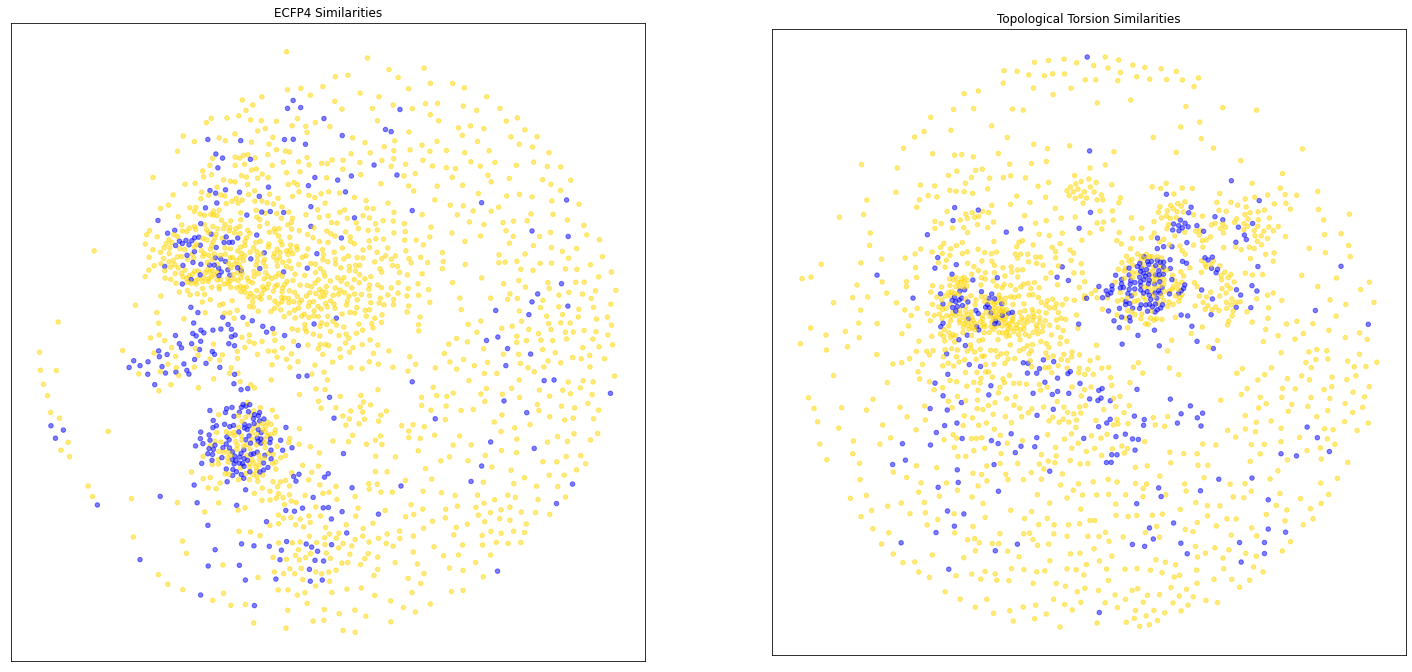

In [49]:
fig1, ax1 = plt.subplots(nrows = 1, ncols = 2, figsize = (25, 25))

xy_coords.plot(kind = "scatter", x = "ecfp4_x", y = "ecfp4_y", c = "plot_color", alpha = 0.5, ax = ax1[0], title = "ECFP4 Similarities")
xy_coords.plot(kind = "scatter", x = "toptorsion_x", y = "toptorsion_y", c = "plot_color", alpha = 0.5, ax = ax1[1], title = "Topological Torsion Similarities")

for subplot in ax1:
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
    subplot.set_aspect("equal")

There is not a clear winner here; although topological torsion similarities give one particularly tight cluster of floral molecules, the other floral molecules are quite disperse. Extended-connectivity fingerprints seem to do a slightly better job of providing several (3-ish) primary clusters of floral molecules. That said, neither method has given a particularly striking partitioning of floral vs. not-floral molecules.

I will **move forward with extended-connectivity fingerprinting** because it provides a slightly more digestable visual representation highlighting clusters of similar floral-smelling molecules.

### Threshold for drawing edge connections

Another big variable that could impact the quality of the visualization is: how similar should molecules be before their numerical similarity is considered when placing them on the plot? In network parlance, what threshold similarity value should be used before drawing an edge between two nodes (molecules)?

For chemical space networks, published studies seem to rely on only the 2 ~ 5 % highest similarity scores. I will examine a slightly broader window to see the impact of this parameter.

#### Export the data to CSV

In [50]:
select_fractions = [0.02, 0.035, 0.05, 0.1]

In [51]:
for fraction in select_fractions:
    select_edges(matrix_ecfp4, fraction, "work-in-progress/ecfp4-similarities")

Selection fraction:  0.02 
Nodes:  1616
Wrote to:  work-in-progress/ecfp4-similarities0.02.csv 

Selection fraction:  0.035 
Nodes:  1669
Wrote to:  work-in-progress/ecfp4-similarities0.035.csv 

Selection fraction:  0.05 
Nodes:  1690
Wrote to:  work-in-progress/ecfp4-similarities0.05.csv 

Selection fraction:  0.1 
Nodes:  1716
Wrote to:  work-in-progress/ecfp4-similarities0.1.csv 



#### Plot the similarities in Gephi

As before, I will use Gephi to plot the similarities using the same force-directed algorithm. The Python work pauses briefly.

#### Re-import the xy coordinates

Once again, now that I have finished using Gephi to place the molecules on an xy plane, I can re-import the coordinates for plotting here:

In [52]:
xy_coords_cutoff = pd.read_csv("work-in-progress/ecfp4-similarities0.02-xy.csv", sep = ";", index_col = "Id")
xy_coords_cutoff = xy_coords_cutoff.join(pd.read_csv("work-in-progress/ecfp4-similarities0.035-xy.csv", sep = ";", index_col = "Id"), lsuffix = "-2pct", rsuffix = "-3.5pct")
xy_coords_cutoff2 = pd.read_csv("work-in-progress/ecfp4-similarities0.05-xy.csv", sep = ";", index_col = "Id")
xy_coords_cutoff2 = xy_coords_cutoff2.join(pd.read_csv("work-in-progress/ecfp4-similarities0.1-xy.csv", sep = ";", index_col = "Id"), lsuffix = "-5pct", rsuffix = "-10pct")
xy_coords_cutoff = xy_coords_cutoff.join(xy_coords_cutoff2)
xy_coords_cutoff.index.rename("common_name", inplace = True)
xy_coords_cutoff.head()

,X-2pct,Y-2pct,X-3.5pct,Y-3.5pct,X-5pct,Y-5pct,X-10pct,Y-10pct
common_name,,,,,,,,
(+)-menthofuran,1729.619751,-741.549866,-1054.371704,-1402.552612,1646.660522,939.766663,-1120.999756,1235.480713
menthofuran,1817.312134,-722.256714,-1153.514648,-1407.554077,1605.484253,1004.574280,-1075.739746,1262.304199
1-hepten-3-ol,-334.713470,-1544.645752,1193.191040,-681.897949,-255.618164,1046.041626,-291.185547,-775.554321
1-decen-3-ol,-769.589783,-1092.818604,398.401611,-889.715942,-813.467041,737.475586,120.469864,-868.430725
1-hexen-3-ol,-101.343170,-1629.160645,1418.427979,-637.535095,44.055115,1213.855835,-524.732544,-675.254822


Now, append a column to color-code the points to indicate whether or not the molecule smells floral:

In [53]:
xy_coords_cutoff["is_floral"] = aromas["floral"]
xy_coords_cutoff["plot_color"] = ["blue" if is_floral == 1 else "gold" for is_floral in xy_coords_cutoff["is_floral"].tolist()]

#### Visualize!

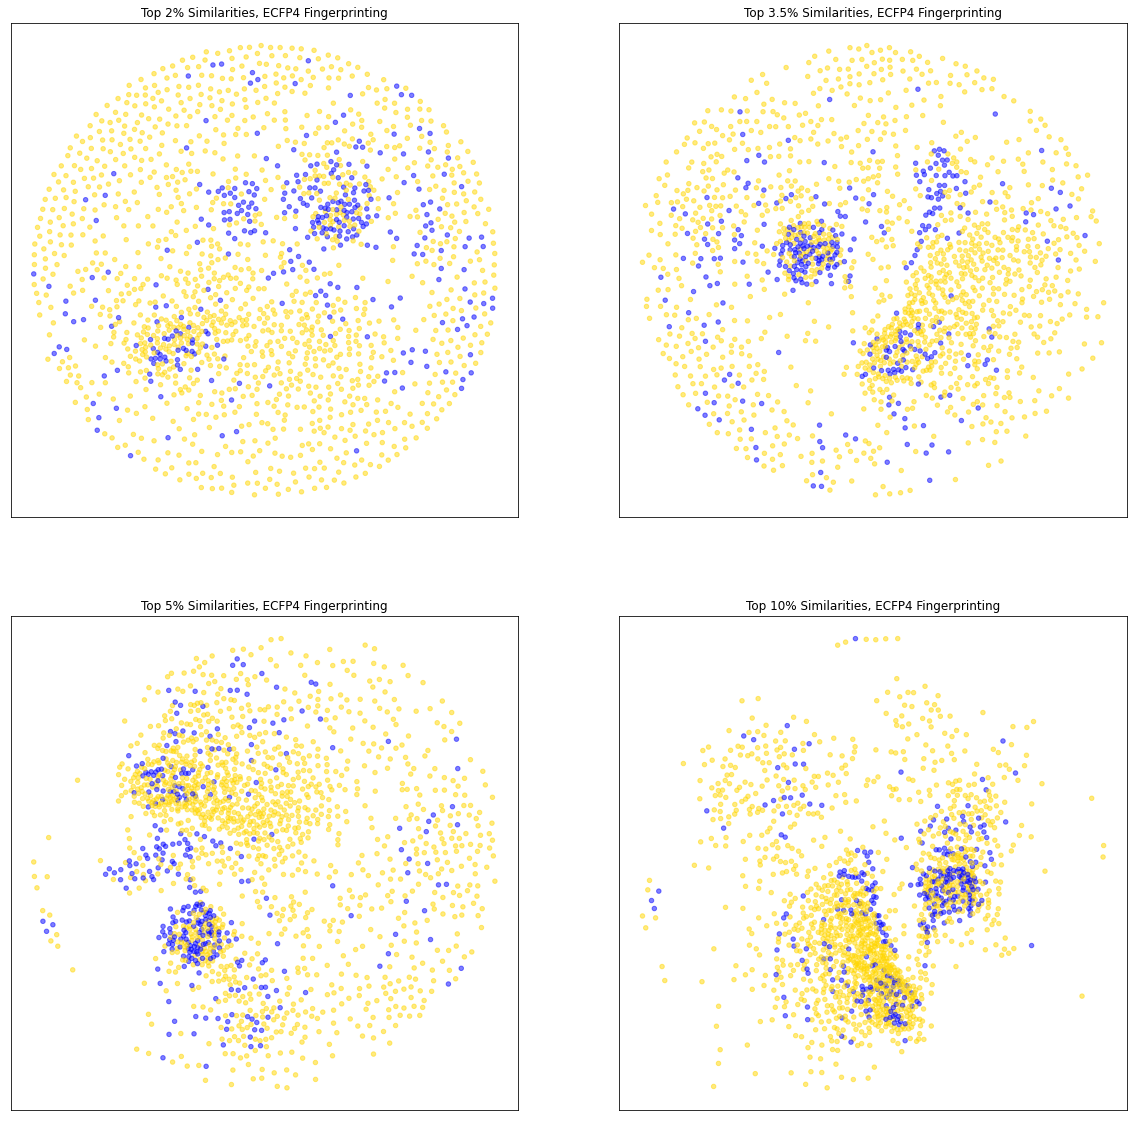

In [54]:
fig2, ax2 = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 20))

xy_coords_cutoff.plot(kind = "scatter", x = "X-2pct", y = "Y-2pct", c = "plot_color", alpha = 0.5, ax = ax2[0,0], title = "Top 2% Similarities, ECFP4 Fingerprinting")
xy_coords_cutoff.plot(kind = "scatter", x = "X-3.5pct", y = "Y-3.5pct", c = "plot_color", alpha = 0.5, ax = ax2[0,1], title = "Top 3.5% Similarities, ECFP4 Fingerprinting")
xy_coords_cutoff.plot(kind = "scatter", x = "X-5pct", y = "Y-5pct", c = "plot_color", alpha = 0.5, ax = ax2[1,0], title = "Top 5% Similarities, ECFP4 Fingerprinting")
xy_coords_cutoff.plot(kind = "scatter", x = "X-10pct", y = "Y-10pct", c = "plot_color", alpha = 0.5, ax = ax2[1,1], title = "Top 10% Similarities, ECFP4 Fingerprinting")

for row in ax2:
    for subplot in row:
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)

The visual impact of varying the threshold for connecting two molecules is really striking. Using the 10% highest similarity scores is clealry too high; nodes overlap extensively. On the opposite end of the spectrum using only the top 2% of similarities does not give enough clustering to be visually meaningful. Between 3.5% and 5%, selecting the 3.5% highest similarity scores looks like it offers a reasonable compromise of clustering the floral molecules without giving too much overlap with non-floral molecules.

Moving forward, I will use the **3.5% highest similarity scores**.

## Export the labeled data

I will finish creating the infographic outside of Python. (See the general workflow under the "Create the infographic" heading, below). As a next step, I need to export the data in a well-structured format.

Although Gephi made it easy to import CSV data to generate the plots above, it cannot readily read *labeled* data (i.e.: "floral" or "not floral") data from a CSV matrix like the ones I have created. The simplest workaround I found was to translate the matrix above into a `networkx` network, then export it to an XML file readable by Gephi.

### Create a list of nodes

First, I'll need to create a list of nodes (that is, individual molecules) and whether or not they smell floral. Each molecule will be one dict in this list:

In [55]:
nodes = []
def list_nodes(row):
    chem_name = row.name
    floral = row["floral"]
    nodes.append(dict(id = chem_name,
                      is_floral = floral))
aromas.apply(list_nodes, axis = "columns")
print("Found nodes: ", len(nodes))

Found nodes:  1728


An example of the requisite formatting looks like this:

In [56]:
nodes[0]

{'id': '(+)-menthofuran', 'is_floral': 1.0}

### Create a list of edges

Next, I need a list of edges (that is, similarity scores for pairs of molecules). Each similarity score will be stored in one dict in a list.

In [57]:
edges = []
keep_fraction = 0.035

cutoff = matrix_ecfp4.melt().quantile(1 - keep_fraction, numeric_only = True).value
filtered = matrix_ecfp4[matrix_ecfp4 >= cutoff]

# Drop self-to-self similarities of 1
np.fill_diagonal(filtered.values, np.nan)
# Drop nodes with no edges
filtered = filtered.dropna(how = "all", axis = "index")
filtered = filtered.dropna(how = "all", axis = "columns")

for column, series in filtered.items():
    for index in series.index:
        similarity = series[index]
        if not math.isnan(similarity):
            edges.append(dict(source = column,
                              target = index,
                              value = similarity))

In [58]:
edges[-5:]

[{'source': 'ambrettolide',
  'target': '3-methylcyclopentadecanone',
  'value': 0.25757575757575757},
 {'source': 'ambrettolide',
  'target': '5-cyclohexadecen-1-one',
  'value': 0.4824561403508772},
 {'source': 'ambrettolide',
  'target': 'cyclohexadecanone',
  'value': 0.2518518518518518},
 {'source': 'ambrettolide',
  'target': '1,4-dioxacycloheptadecane-5,17-dione',
  'value': 0.3435114503816794},
 {'source': 'ambrettolide',
  'target': 'oxacyclohexadecen-2-one',
  'value': 0.42016806722689076}]

### Assemble into a dict

In [59]:
net_dict = dict(nodes = nodes, links = edges)

### Read into NetworkX and export XML

In [60]:
import networkx as nx

In [61]:
network = nx.node_link_graph(net_dict)

In [63]:
nx.write_gexf(network, "work-in-progress/networkx_export.gexf")

## Build the infographic

Using the parameters identified above (3.5% highest similarity scores calculated using 4-bond radius extended-connectivity fingerprinting), I will move to other tools to finish creating an infographic. From a high level, the overall workflow is roughly:
1. Calculate extended-connectivity fingerprints (4-bonds) for all molecules in the dataset using Python/RDKit (already done above)
1. Calculate Tanimoto similarity scores for all pairs of molecular fingerprints using Python/RDKit (already done above)
1. Filter the similarity scores, retaining only the 3.5% greatest similarities between pairs of molecules using Python (already done above)
1. Export the similarity data -- including labels indicating whether or not each molecule smells floral -- to a Gephi-readable XML format (already done above)
1. Place molecules on the graphic (a *chemical space network*) so that similar molecules are located near one another using Gephi & the Fruchterman-Reingold force-directed algorithm.
1. Add visual appeal and additional information using GIMP.

## The finished product!

The finished graphic looks like this:

![Chemical space network of floral molecules](floral-chemical-network.png)